In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from config.config import Config
from utils.helper_functions import create_X_y
from utils.helper_fns_for_optuna import load_optimized_model
from models.baseline.baseline_cnn import BinaryCNN, AnimalDataset


In [2]:
def cross_validate_model(model_name, animal_class, k_folds=5):
    """
    Perform k-fold cross-validation on a specified model and animal class
    """
    # Load data
    print(f"Loading data for {animal_class[0]}...")
    X, y = create_X_y(animal_class)
    
    # Initialize K-Fold
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=Config.RANDOM_SEED)
    
    # Initialize lists to store metrics
    fold_accuracies = []
    fold_losses = []
    
    print(f"Starting {k_folds}-fold cross-validation...")
    
    # Iterate through folds
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Create data loaders for this fold
        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        
        # Create datasets
        dataset = AnimalDataset(X, y)
        train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
        optuna = False
        # Load model for this fold
        if 'optuna' in model_name:
            model, _ = load_optimized_model(model_name)
            optuna = True
        else:
            model = BinaryCNN().to(Config.device)
            model.load_state_dict(torch.load(f"{Config.WEIGHTS_DIR}/{model_name}_model.pth"))
        
        # Evaluate model
        model.eval()
        correct = 0
        total = 0
        running_loss = 0
        criterion = nn.BCEWithLogitsLoss()
        
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs = inputs.to(Config.device)
                
                if optuna:
                    labels = labels.unsqueeze(1)
                labels = labels.to(Config.device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if optuna:
                    outputs = torch.sigmoid(outputs)
                else:
                    outputs = outputs.clamp(min=0, max=1)
            
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        
        # Calculate metrics for this fold
        fold_accuracy = 100 * correct / total
        fold_loss = running_loss / len(val_loader)
        
        fold_accuracies.append(fold_accuracy)
        fold_losses.append(fold_loss)
        
        print(f"Fold {fold + 1} - Accuracy: {fold_accuracy:.2f}%, Loss: {fold_loss:.4f}")
    
    # Calculate and print summary statistics
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    print(f"\nCross-validation complete!")
    print(f"Mean Accuracy: {mean_accuracy:.2f}% (±{std_accuracy:.2f})")
    
    return fold_accuracies, fold_losses


In [3]:
def evaluate_model_on_other_classes(model_name, all_classes):
    """
    Evaluate a model on all animal classes and create a performance matrix
    """
    results = {}
    optuna = False
    # Load the model
    if 'optuna' in model_name:
        model, _ = load_optimized_model(model_name)
        optuna = True
    else:
        model = BinaryCNN().to(Config.device)
        model.load_state_dict(torch.load(f"{Config.WEIGHTS_DIR}/{model_name}_model.pth"))
    
    model.eval()
    
    # Test on each class
    for animal_class in all_classes:
        animal_name = animal_class[0]
        print(f"\nEvaluating on {animal_name} dataset...")
        
        # Load data for this class
        X, y = create_X_y(animal_class)
        dataset = AnimalDataset(X, y)
        loader = DataLoader(dataset, batch_size=32, shuffle=False)
        
        # Evaluate
        correct = 0
        total = 0
        running_loss = 0
        criterion = nn.BCEWithLogitsLoss()  
        
        with torch.inference_mode():
            for inputs, labels in loader:
                inputs = inputs.to(Config.device)
                
                if optuna:
                    labels = labels.unsqueeze(1)
                labels = labels.to(Config.device)
                
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                if optuna:
                    outputs = torch.sigmoid(outputs)
                else:
                    outputs = outputs.clamp(min=0, max=1)   
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        
        # Calculate metrics
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(loader)
        
        results[animal_name] = {
            'accuracy': accuracy,
            'loss': avg_loss
        }
        
        print(f"Accuracy on {animal_name}: {accuracy:.2f}%")
        print(f"Loss on {animal_name}: {avg_loss:.4f}")
    
    return results

In [4]:
def main():
    # Define all classes
    test_classes = {
        'tiger': ['tiger_for_test', 'Tiger_negative_class_for_test'],
        'elephant': ['elephant_for_test', 'Elephant_negative_class_for_test'],
        'fox': ['fox_for_test', 'Fox_negative_class_for_test']
    }
    all_classes = [test_classes['tiger'], test_classes['elephant'], test_classes['fox']]
    
    # Define all models to evaluate
    models = [
        'tiger_baseline',
        'elephant_baseline',
        'fox_baseline',
        'tiger_optuna_final',
        'elephant_optuna_final',
        'fox_optuna_final'
    ]
    
    # Store all results
    cv_results = {}
    cross_class_results = {}
    
    # Perform cross-validation for each model
    print("Performing cross-validation...")
    for model_name in models:
        animal_name = model_name.split('_')[0]
        # Use the dictionary to look up the correct class
        animal_class = test_classes[animal_name]
        
        print(f"\nCross-validating {model_name}...")
        accuracies, losses = cross_validate_model(model_name, animal_class)
        cv_results[model_name] = {
            'accuracies': accuracies,
            'losses': losses
        }
    
    # Evaluate each model on other classes
    print("\nEvaluating models on other classes...")
    for model_name in models:
        print(f"\nEvaluating {model_name}...")
        results = evaluate_model_on_other_classes(model_name, all_classes)
        cross_class_results[model_name] = results
    
    return cv_results, cross_class_results

In [5]:
def visualize_results(cv_results, cross_class_results):
    # Plot cross-validation results
    plt.figure(figsize=(15, 5))
    
    # Box plot of accuracies
    plt.subplot(1, 2, 1)
    accuracies_data = [cv_results[model]['accuracies'] for model in cv_results]
    plt.boxplot(accuracies_data, labels=[m.replace('_', '\n') for m in cv_results.keys()])
    plt.title('Cross-validation Accuracies')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    
    # Heatmap of cross-class performance
    plt.subplot(1, 2, 2)
    models = list(cross_class_results.keys())
    # Use the full test class names that match our data structure
    animals = ['tiger_for_test', 'elephant_for_test', 'fox_for_test']
    # For display purposes, we'll use shortened names
    display_names = ['tiger', 'elephant', 'fox']
    
    performance_matrix = np.zeros((len(models), len(animals)))
    for i, model in enumerate(models):
        for j, animal in enumerate(animals):
            performance_matrix[i, j] = cross_class_results[model][animal]['accuracy']
    
    plt.imshow(performance_matrix, cmap='YlOrRd')
    plt.colorbar(label='Accuracy (%)')
    # Use the shorter display names for the plot
    plt.xticks(range(len(display_names)), display_names)
    plt.yticks(range(len(models)), [m.replace('_', '\n') for m in models])
    plt.title('Cross-class Performance')
    
    plt.tight_layout()
    plt.show()

In [6]:
cv_results, cross_class_results = main()

Performing cross-validation...

Cross-validating tiger_baseline...
Loading data for tiger_for_test...
Starting 5-fold cross-validation...

Fold 1/5
Fold 1 - Accuracy: 70.00%, Loss: 0.5739

Fold 2/5
Fold 2 - Accuracy: 100.00%, Loss: 0.6591

Fold 3/5
Fold 3 - Accuracy: 90.00%, Loss: 0.5649

Fold 4/5
Fold 4 - Accuracy: 66.67%, Loss: 0.5966

Fold 5/5
Fold 5 - Accuracy: 88.89%, Loss: 0.5318

Cross-validation complete!
Mean Accuracy: 83.11% (±12.72)

Cross-validating elephant_baseline...
Loading data for elephant_for_test...
Starting 5-fold cross-validation...

Fold 1/5
Fold 1 - Accuracy: 80.00%, Loss: 0.5376

Fold 2/5
Fold 2 - Accuracy: 100.00%, Loss: 0.5514

Fold 3/5
Fold 3 - Accuracy: 75.00%, Loss: 0.3905

Fold 4/5
Fold 4 - Accuracy: 25.00%, Loss: 1.1267

Fold 5/5
Fold 5 - Accuracy: 100.00%, Loss: 0.4226

Cross-validation complete!
Mean Accuracy: 76.00% (±27.46)

Cross-validating fox_baseline...
Loading data for fox_for_test...
Starting 5-fold cross-validation...

Fold 1/5
Fold 1 - Accura

/tmp/ipykernel_63759/159923495.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracies_data, labels=[m.replace('_', '\n') for m in cv_results.keys()])


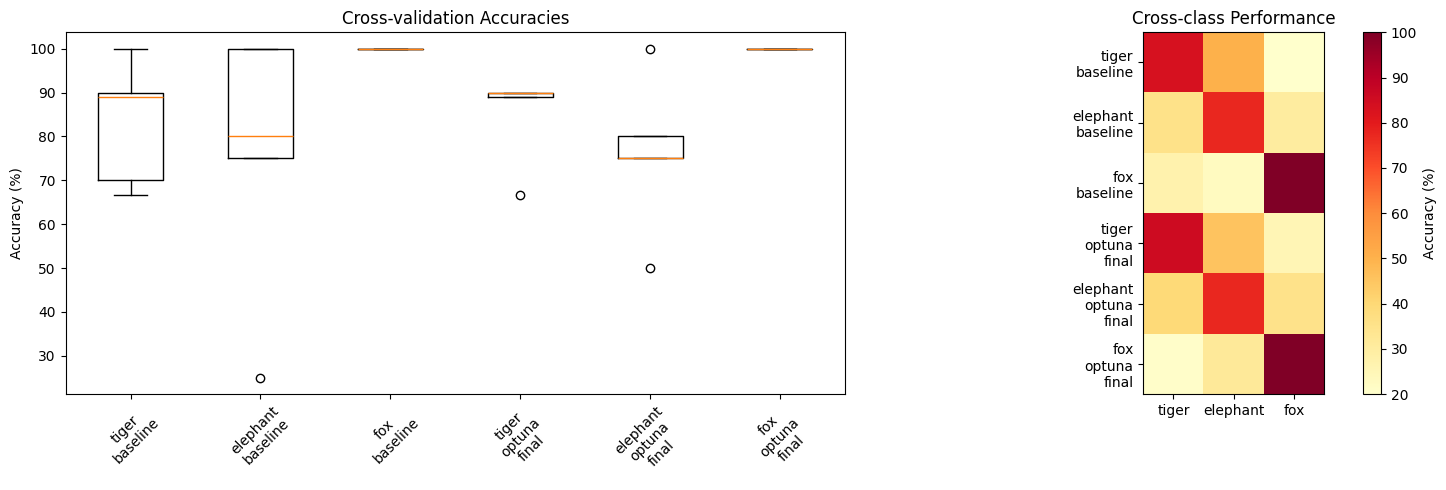

In [7]:
visualize_results(cv_results, cross_class_results)